In [1]:
%tensorflow_version 2.x

In [48]:
import glob
from tensorflow.keras.preprocessing.sequence import pad_sequences
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.svm import SVC
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.layers import *
import tensorflow.keras.backend as K
from tqdm import tqdm
import json

In [3]:
!nvidia-smi

Wed Mar  3 20:53:18 2021       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 460.39       Driver Version: 460.32.03    CUDA Version: 11.2     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla P100-PCIE...  Off  | 00000000:00:04.0 Off |                    0 |
| N/A   34C    P0    26W / 250W |      0MiB / 16280MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

In [4]:
tf.test.gpu_device_name()

'/device:GPU:0'

# **understanding the dataset and get some intuitive ideas**

In [5]:
dir = '/content/drive/MyDrive/Eluvio_movie_data'

In [6]:
movie0_path = '/content/drive/MyDrive/Eluvio_movie_data/tt0052357.pkl'

In [7]:
dic0 = pd.read_pickle(movie0_path)

In [8]:
dic0

{'action': tensor([[0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0000],
         [0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0000],
         [0.0000, 5.5101, 0.0000,  ..., 0.0000, 0.0132, 3.0242],
         ...,
         [0.0000, 5.7000, 0.0000,  ..., 0.0000, 0.0000, 0.1954],
         [0.0000, 4.5412, 0.0000,  ..., 0.0000, 0.1389, 1.3127],
         [0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0000]]),
 'audio': tensor([[-0.0993, -0.0711, -0.0708,  ..., -0.0829, -0.0911, -0.1051],
         [-0.0943, -0.0590, -0.0602,  ..., -0.0682, -0.0753, -0.0831],
         [-0.0442, -0.0324, -0.0318,  ..., -0.0332, -0.0386, -0.0454],
         ...,
         [ 0.0216, -0.0060, -0.0127,  ..., -0.0135, -0.0496, -0.0513],
         [-0.0800, -0.0120, -0.0191,  ..., -0.0272, -0.0592, -0.0654],
         [-0.1281, -0.0604, -0.0645,  ..., -0.0776, -0.0705, -0.0774]]),
 'cast': tensor([[ 0.0000,  0.0000,  0.0000,  ...,  0.0000,  0.0000,  0.0000],
         [ 0.0000,  0.0000,  0.0000,  ...,  0.0000,  0

In [9]:
for k, v in dic0.items():
    print(k,':', v.shape if not isinstance(v, str) else v)

place : torch.Size([1101, 2048])
cast : torch.Size([1101, 512])
action : torch.Size([1101, 512])
audio : torch.Size([1101, 512])
scene_transition_boundary_ground_truth : torch.Size([1100])
shot_end_frame : torch.Size([1101])
scene_transition_boundary_prediction : torch.Size([1100])
imdb_id : tt0052357


In [10]:
smooth = 0.0000001
def plot_sim(feature_name, smooth):
    feature_sim = [0]
    feature = np.array(dic0[feature_name])
    for i in range(1, 1101):
        feature_sim.append((smooth + np.dot(feature[i-1], feature[i])) / (2048 * smooth + np.dot(np.sqrt(np.sum(np.square(feature[i-1]))), np.sqrt(np.sum(np.square(feature[i]))))))
    plt.figure(figsize=(48, 8))
    x = np.arange(1101)
    plt.plot(x, feature_sim)
    for x, b in enumerate(np.array(dic0['scene_transition_boundary_ground_truth'])):
        if b:
            plt.vlines(x+1, 0, 1, colors = "r", linestyles = "dashed")
    plt.title('feature similarity')
    plt.show()




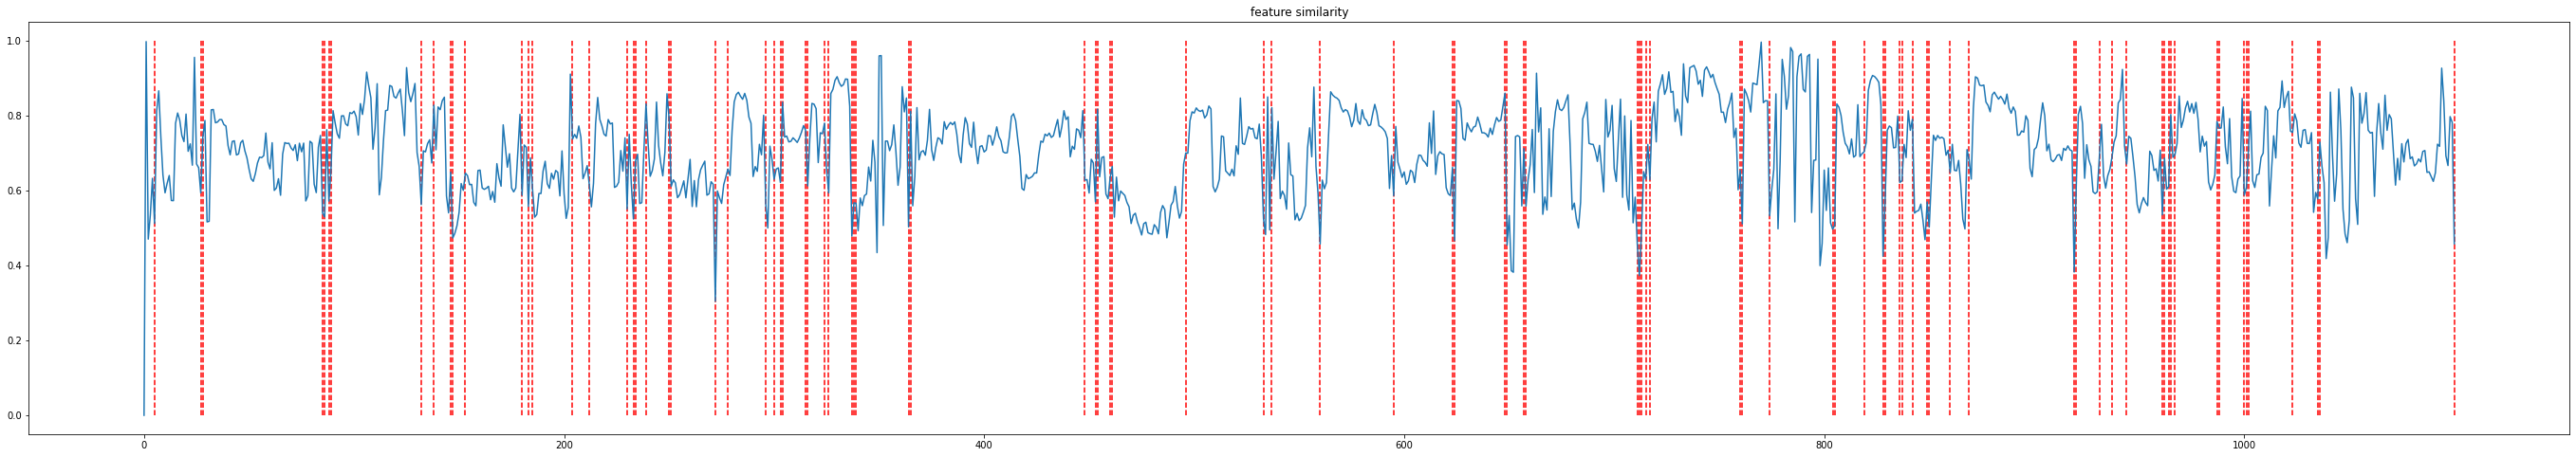

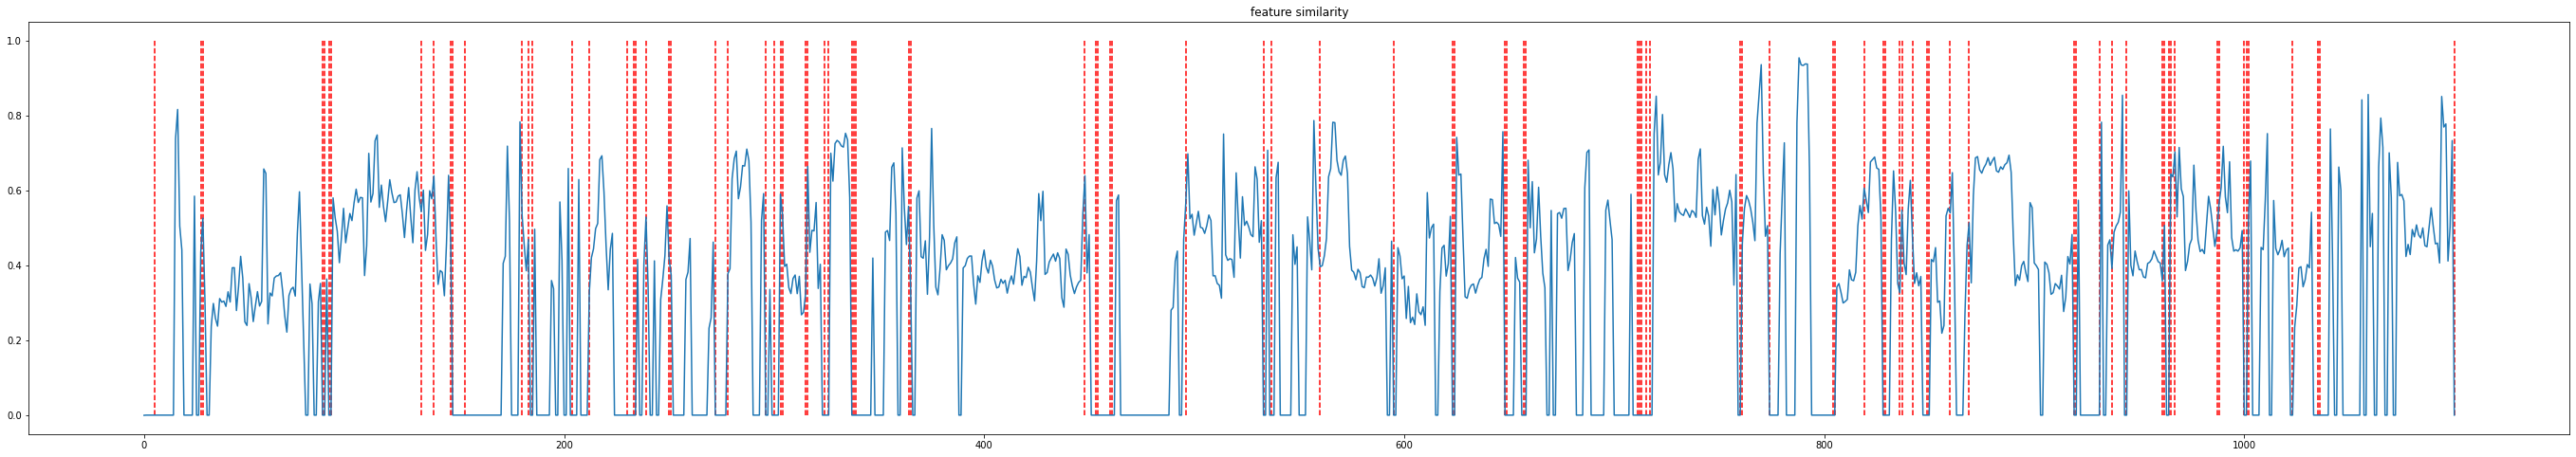

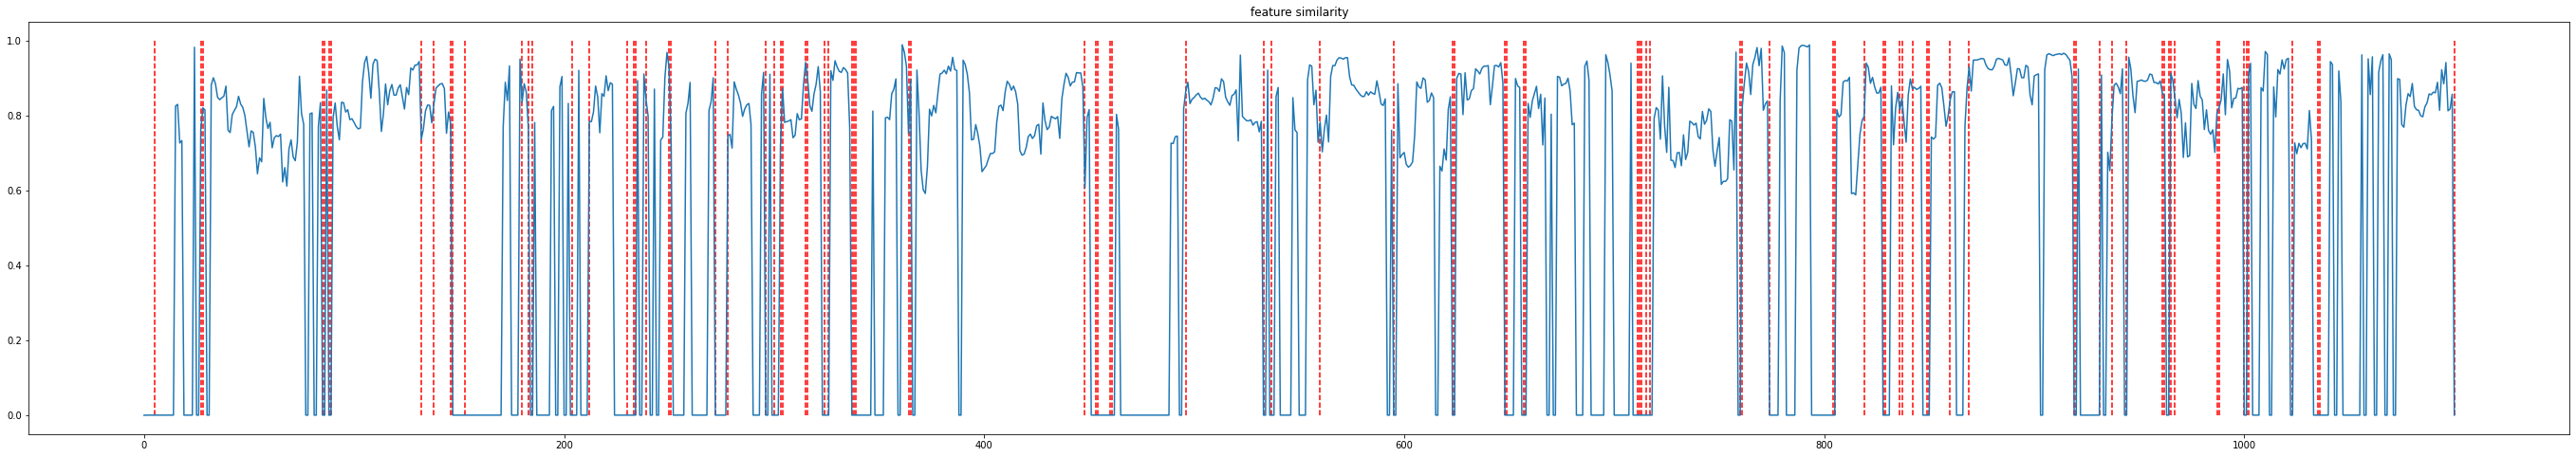

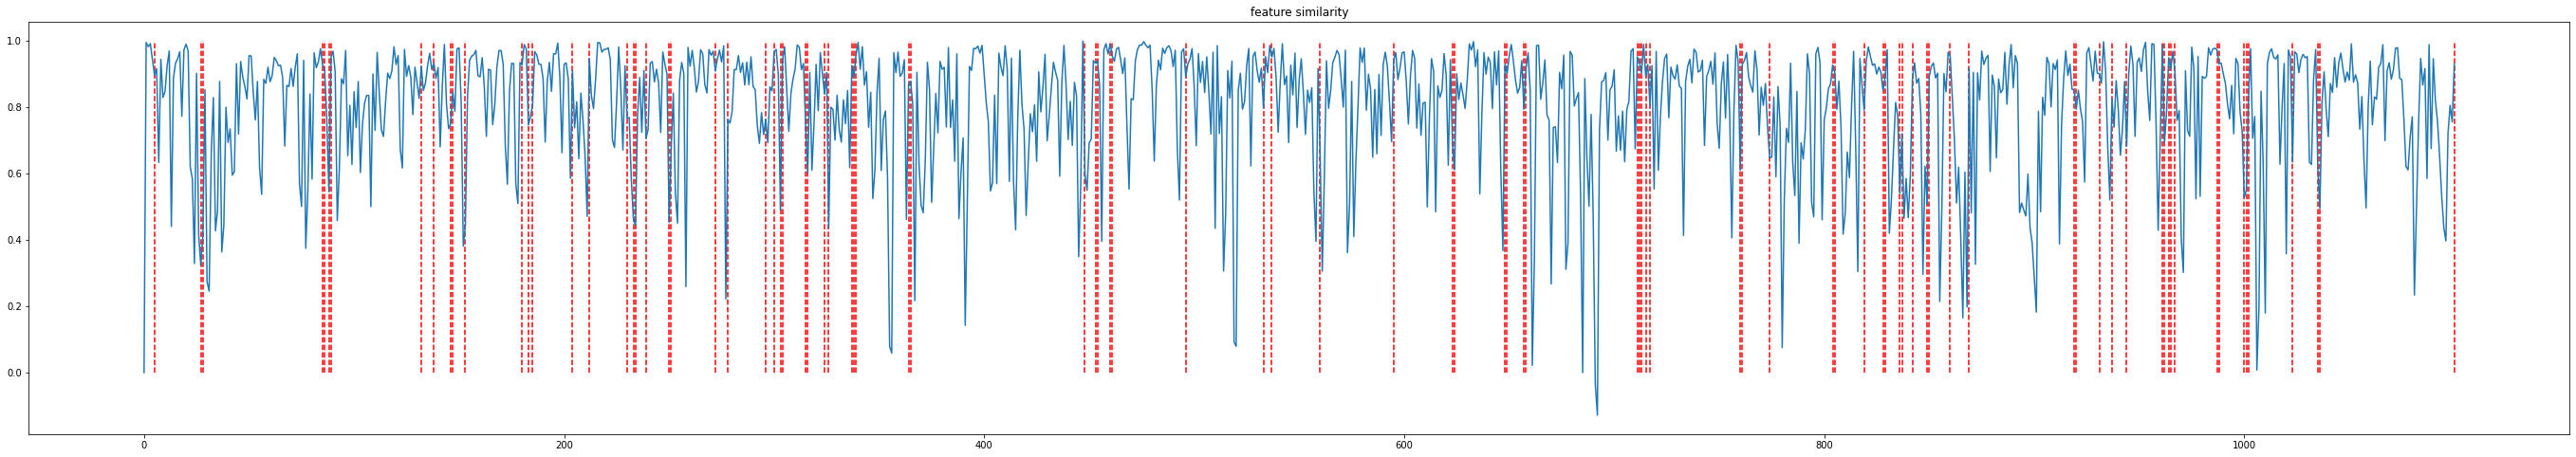

In [11]:
plot_sim('place', smooth)
plot_sim('cast', smooth)
plot_sim('action', smooth)
plot_sim('audio', smooth)

**there are many 0-vectors in action and cast, I don't know if these two vectors will help us to do the classifications**

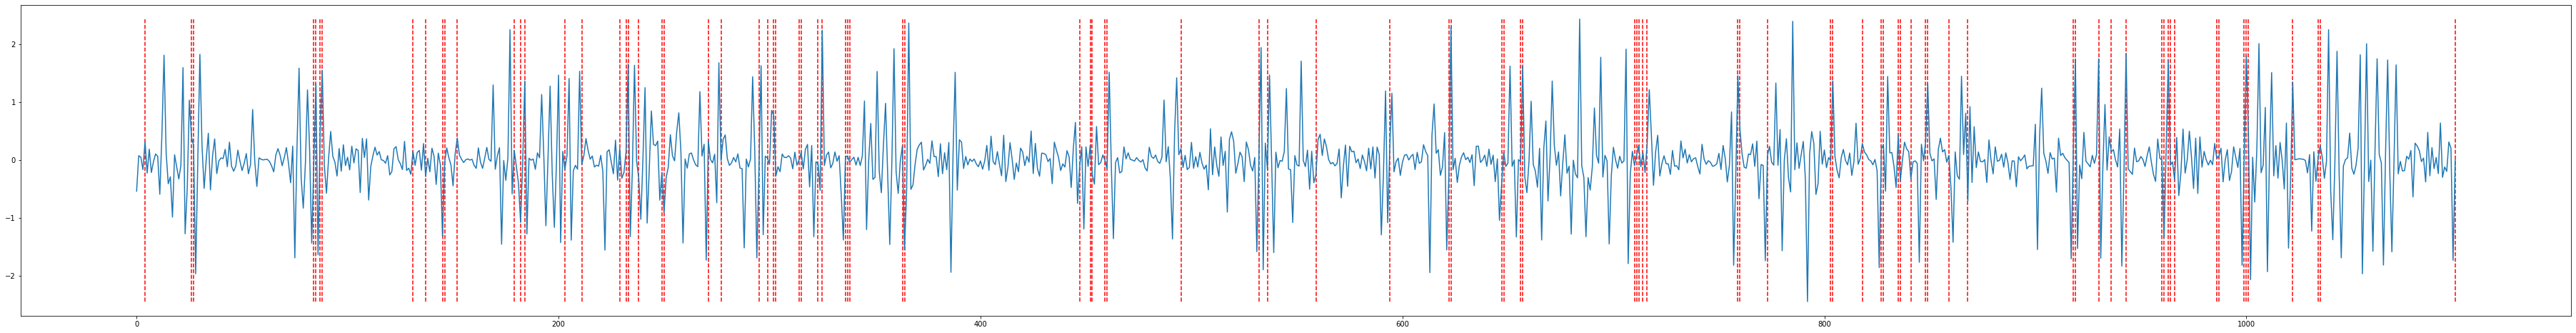

In [12]:
# if a feature is highly similar to its next shot's feature and has very low similarit to its previous one, then it will be comsidered and a scene transition with a high possibility;
# 

sim_diff = []
smooth = 0.001
audio = np.array(dic0['audio'])
cast= np.array(dic0['cast'])
action = np.array(dic0['action'])
place = np.array(dic0['place'])
for i in range(1, 1100):
    temp_sim1 = 0
    temp_sim1 += (np.dot(audio[i-1], audio[i])) / (smooth+np.dot(np.sqrt(np.sum(np.square(audio[i-1]))), np.sqrt(np.sum(np.square(audio[i])))))
    temp_sim1 += (np.dot(place[i-1], place[i])) / (smooth + np.dot(np.sqrt(np.sum(np.square(place[i-1]))), np.sqrt(np.sum(np.square(place[i])))))
    temp_sim1 += (np.dot(cast[i-1], cast[i])) / (smooth+np.dot(np.sqrt(np.sum(np.square(cast[i-1]))), np.sqrt(np.sum(np.square(cast[i])))))
    temp_sim1 += (np.dot(action[i-1], action[i])) / (smooth+np.dot(np.sqrt(np.sum(np.square(action[i-1]))), np.sqrt(np.sum(np.square(action[i])))))

    temp_sim2 = 0
    temp_sim2 += (np.dot(audio[i+1], audio[i])) / (smooth+np.dot(np.sqrt(np.sum(np.square(audio[i+1]))), np.sqrt(np.sum(np.square(audio[i])))))
    temp_sim2 += (np.dot(place[i+1], place[i])) / (smooth + np.dot(np.sqrt(np.sum(np.square(place[i+1]))), np.sqrt(np.sum(np.square(place[i])))))
    temp_sim2 += (np.dot(cast[i+1], cast[i])) / (smooth+np.dot(np.sqrt(np.sum(np.square(cast[i+1]))), np.sqrt(np.sum(np.square(cast[i])))))
    temp_sim2 += (np.dot(action[i+1], action[i])) / (smooth+np.dot(np.sqrt(np.sum(np.square(action[i+1]))), np.sqrt(np.sum(np.square(action[i])))))

    sim_diff.append(temp_sim2 - temp_sim1)

sim_diff.append(0)
x = np.arange(1100)
plt.figure(figsize=(64, 8))
plt.plot(x, sim_diff)
for x, b in enumerate(np.array(dic0['scene_transition_boundary_ground_truth'])):
    if b:
        plt.vlines(x, min(sim_diff), max(sim_diff), colors = "r", linestyles = "dashed")
plt.show()

# it is not very clear

**as we can see, a scene is more likrly to happen around the shot that has high similarity_diff. However, if we only use this mathod, we can't get the excat time_spot**

**instead using the series shape, we can compute a similarity matrix directly, this might be a more intuitive way to show the similarity**

In [13]:
def plot_sim_mat(feature):
    # try directlt compute the correlation
    df_p = pd.DataFrame(feature.transpose())
    corr = df_p.corr()
    plt.figure(figsize=(24, 24))
    plt.imshow(corr)
    plt.colorbar()
    for x, b in enumerate(np.array(dic0['scene_transition_boundary_ground_truth'])):
        if b:
            plt.vlines(x, 0, len(feature), colors = "r", linestyles = "dashed", lw=0.5)
    plt.plot()

# we can find out that, along the diagonal, there are many 'bright_squares', and they should be in the same scene. Thet are splited by some 'dark_squares'
# here we are only considering place-feature. so we might not predict all the scene-transition-spot.
# if we consider other features, (cast, action, audio), we might get a better result

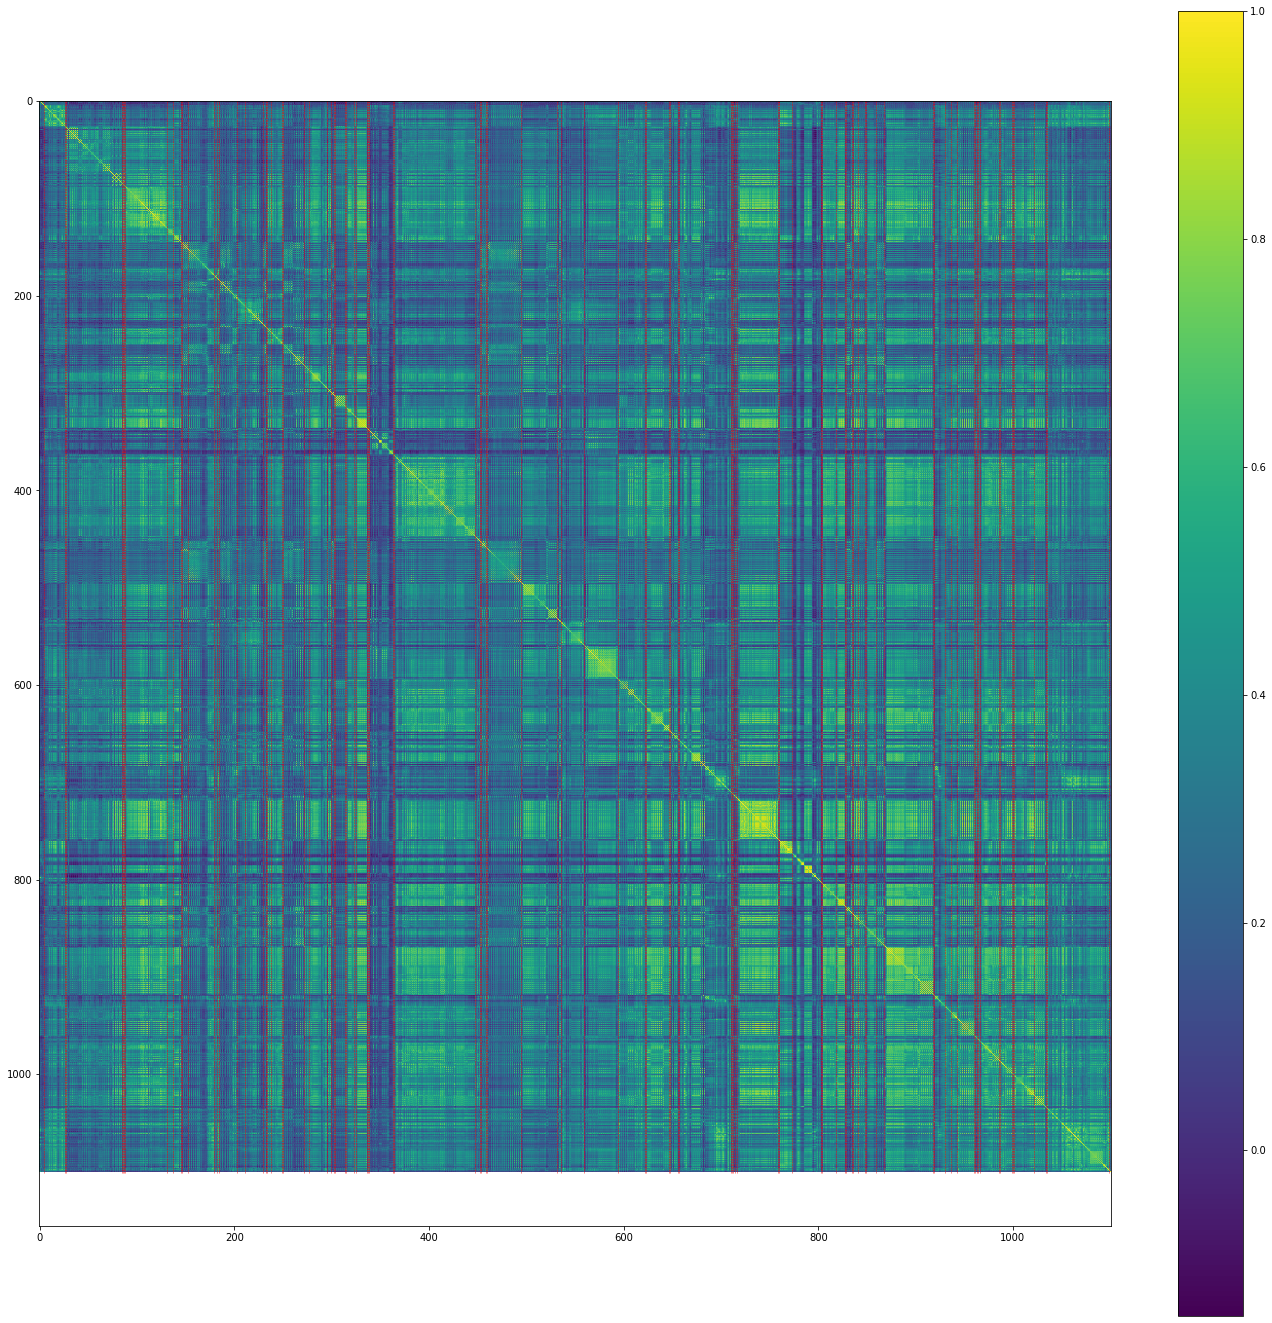

In [14]:
plot_sim_mat(place)

# **similarity seems to be a possible way to get the scene-transition-spot, let's do some simple classification works**

In [ ]:
def get_sim_diffs(feature, smooth):
    sim_diff = []
    l, dim = feature.shape

    for i in range(1, l-1):
        temp_sim1 = (smooth + np.dot(feature[i-1], feature[i])) / (dim*smooth+np.dot(np.sqrt(np.sum(np.square(feature[i-1]))), np.sqrt(np.sum(np.square(feature[i])))))
        temp_sim2 = (smooth + np.dot(feature[i+1], feature[i])) / (dim*smooth+np.dot(np.sqrt(np.sum(np.square(feature[i+1]))), np.sqrt(np.sum(np.square(feature[i])))))
        sim_diff.append(temp_sim2 - temp_sim1)

    i = l-1
    temp_sim1 = (smooth + np.dot(feature[i-1], feature[i])) / (dim*smooth + np.dot(np.sqrt(np.sum(np.square(feature[i-1]))), np.sqrt(np.sum(np.square(feature[i])))))
    temp_sim2 = (smooth + np.dot(feature[i], feature[i])) / (dim*smooth + np.dot(np.sqrt(np.sum(np.square(feature[i]))), np.sqrt(np.sum(np.square(feature[i])))))
    sim_diff.append(temp_sim2 - temp_sim1)

    return sim_diff

In [ ]:
def make_training_set(feature_dic):
    smooth = 0.0000001
    audio = np.array(feature_dic['audio'])
    cast= np.array(feature_dic['cast'])
    action = np.array(feature_dic['action'])
    place = np.array(feature_dic['place'])

    audio_sim_diffs = get_sim_diffs(audio, smooth)
    place_sim_diffs = get_sim_diffs(place, smooth)
    action_sim_diffs = get_sim_diffs(action, smooth)
    cast_sim_diffs = get_sim_diffs(cast, smooth)

    train_x = [[p, c, ac, au] for p, c, ac, au in zip(audio_sim_diffs, place_sim_diffs, action_sim_diffs, audio_sim_diffs)]
    labels = feature_dic['scene_transition_boundary_ground_truth']
    
    return train_x, labels

In [ ]:
filenames = []
for f in glob.glob(dir+'/*'):
    filenames.append(f)

In [ ]:
train_X = []
train_Y = []
for f in tqdm(filenames):
    if f.endswith('pkl')
    dic = pd.read_pickle(f)
    train_x, labels = make_training_set(dic)
    train_X.extend(train_x)
    train_Y.extend(labels)

In [ ]:
pos_rate = sum(train_Y)/len(train_X)

In [ ]:
pos_rate

**unbalanced dataset, using different weights on the dataset**

In [ ]:
train_Y = list(map(lambda x: 1 if x else 0, train_Y))

In [ ]:
train_X_arr = np.array(train_X)
train_Y_arr = np.array(train_Y)

In [ ]:
from sklearn.model_selection import train_test_split
train_features, test_features, train_labels, test_labels = train_test_split(train_X_arr, train_Y_arr, test_size=0.2, random_state=42)

In [ ]:
train_features = np.array(train_features)
train_labels = np.array(train_labels)
test_features = np.array(test_features)
test_labels = np.array(test_labels)

In [ ]:
svc = SVC()

In [ ]:
weights = [pos_rate if i == 0 else 1-pos_rate for i in train_labels]

In [ ]:
%%time
svc.fit(train_features, train_labels, sample_weight=weights)

In [ ]:
test_preds = svc.predict(test_features)

In [ ]:
from sklearn.metrics import f1_score, recall_score, precision_score

In [ ]:
f1 = f1_score(test_labels, test_preds)
recall = recall_score(test_labels, test_preds)
precision = precision_score(test_labels, test_preds)

In [ ]:
f1, recall, precision

**only use the sim_diff is a bad way to do this prediction work**
we can conclude that a scene_transition_spot not only relies on the similarity_diff on that time spot, but also relies on the previous time steps
**so using LSTM to do a time-series prediciton is a good way**

# **read the whole dataset**

In [18]:
filenames = []
for f in glob.glob(dir+'/*'):
    filenames.append(f)

In [20]:
place = []
cast = []
action = []
audio = []
truth = []

for f in tqdm(filenames):
    if f.endswith('pkl'):
        dic = pd.read_pickle(f)
        # convert the truth to 0/1 value and insert a 0 value at the head of the truth to pad
        truth.append([0]+[1 if t else 0 for t in dic['scene_transition_boundary_ground_truth']])
        place.append(np.array(dic['place']))
        cast.append(np.array(dic['cast']))
        action.append(np.array(dic['action']))
        audio.append(np.array(dic['audio']))


100%|██████████| 75/75 [00:41<00:00,  1.81it/s]


In [21]:
total = len(truth)

In [22]:
total

64

In [23]:
maxlen = max([len(t) for t in truth])
maxlen

3096

In [24]:
minlen = min([len(t) for t in truth])
minlen

607

In [25]:
def get_sim_mat(feature):
    df_temp = pd.DataFrame(feature.transpose())
    corr = df_temp.corr()
    return corr.values

# **Using the original features instead of using the similarity metrix**

## **make a batch_generator**

In [ ]:
def batch_generator(batch_size):
    # Infinite loop.
    while True:
        idx = np.random.randint(total, size=batch_size)
        batch_truth = [truth[i] for i in idx]
        maxlen = max([len(t) for t in batch_truth])

        # padding the ground_truth to the max_len in this batch
        batch_truth = pad_sequences(batch_truth, maxlen=maxlen, padding='post')
        
        batch_place = []
        batch_cast =[]
        batch_action = []
        batch_audio = []

        for i in idx:
            p = place[i]
            c = cast[i]
            ac = action[i]
            au = audio[i]   
            # pad each feature with its last element
            p = np.concatenate((p, np.repeat(np.expand_dims(p[-1], 0), (maxlen-len(p)), 0)), axis=0)
            c = np.concatenate((c, np.repeat(np.expand_dims(c[-1], 0), (maxlen-len(c)), 0)), axis=0)
            ac = np.concatenate((ac, np.repeat(np.expand_dims(ac[-1], 0), (maxlen-len(ac)), 0)), axis=0)
            au = np.concatenate((au, np.repeat(np.expand_dims(au[-1], 0), (maxlen-len(au)), 0)), axis=0)
            batch_place.append(p)
            batch_cast.append(c)
            batch_action.append(ac)
            batch_audio.append(au)

        x_data = {
            'place_input': np.array(batch_place),
            'cast_input': np.array(batch_cast),
            'action_input': np.array(batch_action),
            'audio_input': np.array(batch_audio)
        }

        # Dict for the output-data.
        y_data = {
            'output': batch_truth
        }
        
        yield (x_data, y_data)


In [ ]:
gen = batch_generator(4)

In [ ]:
batch = next(gen)

In [ ]:
batch[1]['output'].shape, batch[0]['place_input'].shape

((4, 2151), (4, 2151, 2048))

## **Method1: we can use Bi_LSTM to predict**

In [ ]:
# customized softmax -- not sure it we are going to use it
def softmax(x, axis=1):
    ndim = K.ndim(x)
    if ndim == 2:
        return K.softmax(x)
    elif ndim > 2:
        e = K.exp(x - K.max(x, axis=axis, keepdims=True))
        s = K.sum(e, axis=axis, keepdims=True)
        return e / s
    else:
        raise ValueError('Cannot apply softmax to a tensor that is 1D')

we are going to make a NN with 4 input and 1 output

In [ ]:
place_input = Input(shape=(None, 2048), name='place_input')
cast_input = Input(shape=(None, 512), name='cast_input')
action_input = Input(shape=(None, 512), name='action_input')
audio_input = Input(shape=(None, 512), name='audio_input')

place_h1 = Bidirectional(LSTM(512, return_sequences=True))(place_input)
cast_h1 = Bidirectional(LSTM(128, return_sequences=True))(cast_input)
action_h1 = Bidirectional(LSTM(128, return_sequences=True))(action_input)
audio_h1 = Bidirectional(LSTM(128, return_sequences=True))(audio_input)

place_h2 = Bidirectional(LSTM(128, return_sequences=True))(place_h1)
cast_h2 = Bidirectional(LSTM(32, return_sequences=True))(cast_h1)
action_h2 = Bidirectional(LSTM(32, return_sequences=True))(action_h1)
audio_h2 = Bidirectional(LSTM(32, return_sequences=True))(audio_h1)

place_h3 = Bidirectional(LSTM(32, return_sequences=True))(place_h2)

place_dense = Dense(8, activation='relu')(place_h3)
cast_dense = Dense(8, activation='relu')(cast_h2)
action_dense = Dense(8, activation='relu')(action_h2)
audio_dense = Dense(8, activation='relu')(audio_h2)

merge_feature= Add()([place_dense, cast_dense, action_dense, audio_dense])

pred = Dense(1, activation='sigmoid', name='output')(merge_feature)

model1 = keras.models.Model(inputs=[place_input, cast_input, action_input, audio_input], outputs=[pred])


In [ ]:
model1.summary(line_length=200)

Model: "model_1"
________________________________________________________________________________________________________________________________________________________________________________________________________
Layer (type)                                                      Output Shape                                Param #                 Connected to                                                      
place_input (InputLayer)                                          [(None, None, 2048)]                        0                                                                                         
________________________________________________________________________________________________________________________________________________________________________________________________________
bidirectional (Bidirectional)                                     (None, None, 1024)                          10489856                place_input[0][0]                            

In [ ]:
model1.compile(optimizer='rmsprop', loss='binary_crossentropy', metrics=['accuracy'])

In [ ]:
gen1 = batch_generator(4)

In [ ]:
%%time
history=model1.fit_generator(gen1, steps_per_epoch=16, epochs=20, verbose=1)

/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/engine/training.py:1844: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  warnings.warn('`Model.fit_generator` is deprecated and '


Epoch 1/20
16/16 [==============================] - 988s 59s/step - loss: 0.4020 - accuracy: 0.7883
Epoch 2/20
16/16 [==============================] - 990s 62s/step - loss: 0.2101 - accuracy: 0.9405
Epoch 3/20
16/16 [==============================] - 1073s 68s/step - loss: 0.1866 - accuracy: 0.9472
Epoch 4/20
16/16 [==============================] - 1091s 68s/step - loss: 0.1916 - accuracy: 0.9460
Epoch 5/20
16/16 [==============================] - 992s 64s/step - loss: 0.1971 - accuracy: 0.9431
Epoch 6/20
16/16 [==============================] - 1045s 65s/step - loss: 0.1861 - accuracy: 0.9438
Epoch 7/20
16/16 [==============================] - 1001s 61s/step - loss: 0.1999 - accuracy: 0.9455
Epoch 8/20
16/16 [==============================] - 918s 57s/step - loss: 0.1846 - accuracy: 0.9433
Epoch 9/20
16/16 [==============================] - 867s 55s/step - loss: 0.1876 - accuracy: 0.9410
Epoch 10/20
16/16 [==============================] - 851s 54s/step - loss: 0.2004 - accuracy: 0.

In [ ]:
model1.save_weights('/content/drive/MyDrive/Eluvio_movie_data/bi_lstm_model.h5')

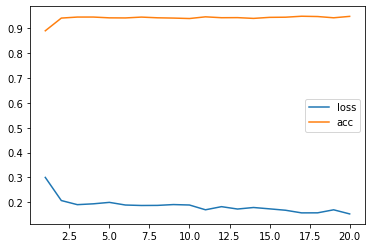

In [ ]:
import matplotlib.pyplot as plt
x = [i for i in range(1, 21)]
plt.plot(x, history.history['loss'], label='loss')
plt.plot(x, history.history['accuracy'], label='acc')
plt.legend()
plt.show()

**the acc seems to be alright, but there is a fetel erroe: it is an super unbalanced dataset, which means if we predict all the shot to be not the transition_spot, we will still have a acc of about 93%...<br><br>and we can see that after training 20 epochs, the acc has already converged, that change afterword won't be very large.So we can almost give up the ideas that use the original features to be the train_set**

In [ ]:
model1.load_weights('/content/drive/MyDrive/Eluvio_movie_data/bi_lstm_model.h5')

In [ ]:
test_place = np.expand_dims(place[0], 0)
test_cast = np.expand_dims(cast[0], 0)
test_action = np.expand_dims(action[0], 0)
test_audio = np.expand_dims(audio[0], 0)

In [ ]:
test = {
        'place_input': test_place,
        'cast_input': test_cast,
        'action_input': test_action,
        'audio_input': test_audio
}

In [ ]:
pred = model1.predict(test)
_pred = pred[0, :, 0]
_pred = list(map(lambda x:1 if x > 0.5 else 0, _pred))

In [ ]:
from sklearn.metrics import f1_score, precision_score, recall_score
print('F1 score: ', f1_score(truth[0], _pred), 'Precision score: ', precision_score(truth[0], _pred), 'Recall score: ', recall_score(truth[0], _pred))

F1 score:  0.3333333333333333 Precision score:  0.7407407407407407 Recall score:  0.21505376344086022


**high precision and low recall, a typical error for a model on an unbalanced dataset**

## **Method2: we can also try attention model, something similar to transformer but much more similar**

**I might not need a padding-mask,
because when I do the padding work, I use the last shot's feature to pad, this means that I don't need the 0-padding mask**

In [ ]:
def scaled_dot_product_attention(q, k, v):

    matmul_qk = tf.matmul(q, k, transpose_b=True)  # matmul_qk shape : (.., seq_len_q, seq_len_k)

    # scale matmul_qk
    dk = tf.cast(tf.shape(k)[-1], tf.float32)
    scaled_attention_logits = matmul_qk / tf.math.sqrt(dk)

    # softmax is normalized on the last axis (seq_len_k) so that the scores
    # add up to 1.
    attention_weights = tf.nn.softmax(scaled_attention_logits, axis=-1)  # attention_weights shape: (..., seq_len_q, seq_len_k)

    output = tf.matmul(attention_weights, v)  # output shape:  (.., seq_len_v, depth_v)

    return output, attention_weights

In [ ]:
class MultiHeadAttention(tf.keras.layers.Layer):
    def __init__(self, d_model, num_heads):
        super(MultiHeadAttention, self).__init__()
        self.num_heads = num_heads
        self.d_model = d_model

        assert d_model % self.num_heads == 0

        self.depth = d_model // self.num_heads

        self.wq = tf.keras.layers.Dense(d_model)
        self.wk = tf.keras.layers.Dense(d_model)
        self.wv = tf.keras.layers.Dense(d_model)

        self.dense = tf.keras.layers.Dense(d_model)

    def split_heads(self, x, batch_size):
        x = tf.reshape(x, (batch_size, -1, self.num_heads, self.depth))
        return tf.transpose(x, perm=[0, 2, 1, 3])

    def call(self, v, k, q):
        batch_size = tf.shape(q)[0]

        q = self.wq(q)  # (batch_size, seq_len, d_model)
        k = self.wk(k)  # (batch_size, seq_len, d_model)
        v = self.wv(v)  # (batch_size, seq_len, d_model)

        q = self.split_heads(q, batch_size)  # (batch_size, num_heads, seq_len_q, depth)
        k = self.split_heads(k, batch_size)  # (batch_size, num_heads, seq_len_k, depth)
        v = self.split_heads(v, batch_size)  # (batch_size, num_heads, seq_len_v, depth)
        
        # seq_len_v = seq_len_k
        # scaled_attention.shape == (batch_size, num_heads, seq_len_q, depth)
        # attention_weights.shape == (batch_size, num_heads, seq_len_q, seq_len_k)
        scaled_attention, attention_weights = scaled_dot_product_attention(q, k, v)
        
        scaled_attention = tf.transpose(scaled_attention, perm=[0, 2, 1, 3])  # (batch_size, seq_len_q, num_heads, depth)

        concat_attention = tf.reshape(scaled_attention,  (batch_size, -1, self.d_model))  # (batch_size, seq_len_q, d_model)

        output = self.dense(concat_attention)  # (batch_size, seq_len_q, d_model)
        return output, attention_weights

In [ ]:
def point_wise_feed_forward_network(d_model, dff):
    return tf.keras.Sequential([
        tf.keras.layers.Dense(dff, activation='relu'),  # (batch_size, seq_len, dff)
        tf.keras.layers.Dense(d_model)  # (batch_size, seq_len, d_model)
    ])

In [ ]:
class EncoderLayer(tf.keras.layers.Layer):
    def __init__(self, d_model, num_heads, dff, rate=0.5):
        super(EncoderLayer, self).__init__()

        self.mha = MultiHeadAttention(d_model, num_heads)
        self.ffn = point_wise_feed_forward_network(d_model, dff)

        self.layernorm1 = tf.keras.layers.LayerNormalization(epsilon=1e-6)
        self.layernorm2 = tf.keras.layers.LayerNormalization(epsilon=1e-6)

        self.dropout1 = tf.keras.layers.Dropout(rate)
        self.dropout2 = tf.keras.layers.Dropout(rate)

        self.dense_input  = tf.keras.layers.Dense(d_model)
    def call(self, x, training=True):

        attn_output, _ = self.mha(x, x, x)  # (batch_size, input_seq_len, d_model)
        attn_output = self.dropout1(attn_output, training=training)
        x_dense = self.dense_input(x)
        out1 = self.layernorm1(x_dense + attn_output)  # (batch_size, input_seq_len, d_model)
        ffn_output = self.ffn(out1)  # (batch_size, input_seq_len, d_model)
        ffn_output = self.dropout2(ffn_output, training=training)
        out2 = self.layernorm2(out1 + ffn_output)  # (batch_size, input_seq_len, d_model)

        return out2

In [ ]:
def get_attention_model():
    place_input = Input(shape=(None, 2048), name='place_input')
    cast_input = Input(shape=(None, 512), name='cast_input')
    action_input = Input(shape=(None, 512), name='action_input')
    audio_input = Input(shape=(None, 512), name='audio_input')
    
    place_h0 = EncoderLayer(512, 8, 128)(place_input)
    
    place_h1 = EncoderLayer(128, 8, 32)(place_h0)
    cast_h1 = EncoderLayer(128, 8, 32)(cast_input)
    action_h1 = EncoderLayer(128, 8, 32)(action_input)
    audio_h1 = EncoderLayer(128, 8, 32)(audio_input)

    place_h2 = EncoderLayer(32, 8, 8)(place_h1)
    cast_h2 = EncoderLayer(32, 8, 8)(cast_h1)
    action_h2 = EncoderLayer(32, 8, 8)(action_h1)
    audio_h2 = EncoderLayer(32, 8, 8)(audio_h1)


    place_dense = Dense(4, activation='relu')(place_h2)
    cast_dense = Dense(4, activation='relu')(cast_h2)
    action_dense = Dense(4, activation='relu')(action_h2)
    audio_dense = Dense(4, activation='relu')(audio_h2)

    merge_feature= Add()([place_dense, cast_dense, action_dense, audio_dense])

    pred = Dense(1, activation='sigmoid', name='output')(merge_feature)

    model3 = keras.models.Model(inputs=[place_input, cast_input, action_input, audio_input], outputs=[pred])
    return model3
    

In [ ]:
atten_model = get_attention_model()

In [ ]:
atten_model.summary(line_length=200)

Model: "model"
________________________________________________________________________________________________________________________________________________________________________________________________________
Layer (type)                                                      Output Shape                                Param #                 Connected to                                                      
place_input (InputLayer)                                          [(None, None, 2048)]                        0                                                                                         
________________________________________________________________________________________________________________________________________________________________________________________________________
encoder_layer (EncoderLayer)                                      (None, None, 512)                           4592768                 place_input[0][0]                              

In [ ]:
atten_model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

In [ ]:
gen3 = batch_generator(2)

In [ ]:
%%time
# I guess using 8 as batch_size is too large to train on colab, because it raise an OOM error
history = atten_model.fit_generator(gen3, steps_per_epoch=16, epochs=40, verbose=1)

/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/engine/training.py:1844: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  warnings.warn('`Model.fit_generator` is deprecated and '


Epoch 1/40
16/16 [==============================] - 106s 6s/step - loss: 1.2751 - accuracy: 0.5024
Epoch 2/40
16/16 [==============================] - 132s 8s/step - loss: 0.6862 - accuracy: 0.9155
Epoch 3/40
16/16 [==============================] - 138s 8s/step - loss: 0.6786 - accuracy: 0.9393
Epoch 4/40
16/16 [==============================] - 95s 6s/step - loss: 0.6725 - accuracy: 0.9396
Epoch 5/40
16/16 [==============================] - 143s 9s/step - loss: 0.6656 - accuracy: 0.9344
Epoch 6/40
16/16 [==============================] - 120s 8s/step - loss: 0.6588 - accuracy: 0.9389
Epoch 7/40
16/16 [==============================] - 102s 6s/step - loss: 0.6530 - accuracy: 0.9333
Epoch 8/40
16/16 [==============================] - 119s 8s/step - loss: 0.6462 - accuracy: 0.9379
Epoch 9/40
16/16 [==============================] - 103s 6s/step - loss: 0.6407 - accuracy: 0.9329
Epoch 10/40
16/16 [==============================] - 119s 7s/step - loss: 0.6332 - accuracy: 0.9434
Epoch 11/4

KeyboardInterrupt: ignored

**by far, I can tell the performance won't be better than LSTM**

## **Method3: also we can treat the img feature vectors as 1-D images, then we can use conv-1d to train the model**

In [ ]:
def get_conv_model():
    place_input = Input(shape=(None, 2048), name='place_input')
    cast_input = Input(shape=(None, 512), name='cast_input')
    action_input = Input(shape=(None, 512), name='action_input')
    audio_input = Input(shape=(None, 512), name='audio_input')

    place_conv1 = Conv1D(filters=512, kernel_size=3, strides=1, padding='same')(place_input)
    cast_conv1 = Conv1D(filters=128, kernel_size=3, strides=1, padding='same')(cast_input)
    action_conv1 = Conv1D(filters=128, kernel_size=3, strides=1, padding='same')(action_input)
    audio_conv1 = Conv1D(filters=128, kernel_size=3, strides=1, padding='same')(audio_input)

    # no pooling layer, because we don't need a larger perceptive field(in my opinion), we just need to focus a local feature

    place_conv2 = Conv1D(filters=128, kernel_size=3, strides=1, padding='same')(place_conv1)
    cast_conv2 = Conv1D(filters=32, kernel_size=3, strides=1, padding='same')(cast_conv1)
    action_conv2 = Conv1D(filters=32, kernel_size=3, strides=1, padding='same')(action_conv1)
    audio_conv2 = Conv1D(filters=32, kernel_size=3, strides=1, padding='same')(audio_conv1)

    place_conv3 = Conv1D(filters=32, kernel_size=3, strides=1, padding='same')(place_conv2)

    place_dense = Dense(8, activation='relu')(place_conv3)
    cast_dense = Dense(8, activation='relu')(cast_conv2)
    action_dense = Dense(8, activation='relu')(action_conv2)
    audio_dense = Dense(8, activation='relu')(audio_conv2)

    merge_feature= Add()([place_dense, cast_dense, action_dense, audio_dense])

    pred = Dense(1, activation='sigmoid', name='output')(merge_feature)

    model2 = keras.models.Model(inputs=[place_input, cast_input, action_input, audio_input], outputs=[pred])
    return model2

In [ ]:
model2 = get_conv_model()

In [ ]:
model2.summary(line_length=200)

Model: "model"
________________________________________________________________________________________________________________________________________________________________________________________________________
Layer (type)                                                      Output Shape                                Param #                 Connected to                                                      
place_input (InputLayer)                                          [(None, None, 2048)]                        0                                                                                         
________________________________________________________________________________________________________________________________________________________________________________________________________
conv1d (Conv1D)                                                   (None, None, 512)                           3146240                 place_input[0][0]                              

In [ ]:
model2.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

In [ ]:
gen2 = batch_generator(4)


In [ ]:
%%time
history=model2.fit_generator(gen2, steps_per_epoch=16, epochs=20, verbose=1)

/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/engine/training.py:1844: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  warnings.warn('`Model.fit_generator` is deprecated and '


Epoch 1/20
16/16 [==============================] - 19s 182ms/step - loss: 1.4249 - accuracy: 0.8418
Epoch 2/20
16/16 [==============================] - 2s 151ms/step - loss: 0.8964 - accuracy: 0.9419
Epoch 3/20
16/16 [==============================] - 3s 161ms/step - loss: 1.0349 - accuracy: 0.9329
Epoch 4/20
16/16 [==============================] - 2s 145ms/step - loss: 0.9437 - accuracy: 0.9388
Epoch 5/20
16/16 [==============================] - 2s 157ms/step - loss: 0.9321 - accuracy: 0.9396
Epoch 6/20
16/16 [==============================] - 3s 153ms/step - loss: 0.8332 - accuracy: 0.9460
Epoch 7/20
16/16 [==============================] - 2s 157ms/step - loss: 0.9266 - accuracy: 0.9399
Epoch 8/20
16/16 [==============================] - 2s 146ms/step - loss: 0.7966 - accuracy: 0.9484
Epoch 9/20
16/16 [==============================] - 2s 137ms/step - loss: 1.0212 - accuracy: 0.9338
Epoch 10/20
16/16 [==============================] - 2s 153ms/step - loss: 1.0025 - accuracy: 0.935

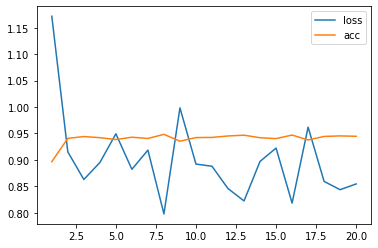

In [ ]:
x = [i for i in range(1, 21)]
plt.plot(x, history.history['loss'], label='loss')
plt.plot(x, history.history['accuracy'], label='acc')
plt.legend()
plt.show()

although the acc seems alright, but the loss is unstable

# **Using the similarity matrix as the features, then feed the Bi_LSTM model**
Intuitively, I think this method should be the best one.

use the similarity vectors as train_x.<br>
however, each movie has different number of shots, so the similarity is of different shape. <br>
if we want to use this feature as its input, we have to padding each feature sequence to the longest seq in the training set.

## **compute sim matrix and make svd decomposition**

In [ ]:
place_sim = []
cast_sim = []
action_sim = []
audio_sim = []


In [ ]:
for i in tqdm(range(64)):
    place_sim.append(get_sim_mat(place[i]))
    cast_sim.append(get_sim_mat(cast[i]))
    action_sim.append(get_sim_mat(action[i]))
    audio_sim.append(get_sim_mat(audio[i]))

100%|██████████| 64/64 [19:30<00:00, 18.29s/it]


In [ ]:
place_sim_svd = []
cast_sim_svd = []
action_sim_svd = []
audio_sim_svd = []

In [ ]:
for i in tqdm(range(64)):
    place_u, _, _ = np.linalg.svd(np.nan_to_num(place_sim[i]))
    place_sim_svd.append(place_u[:, 0:600])

    cast_u, _, _ = np.linalg.svd(np.nan_to_num(cast_sim[i]))
    cast_sim_svd.append(cast_u[:, 0:600])

    action_u, _, _ = np.linalg.svd(np.nan_to_num(action_sim[i]))
    action_sim_svd.append(action_u[:, 0:600])

    audio_u, _, _ = np.linalg.svd(np.nan_to_num(audio_sim[i]))
    audio_sim_svd.append(audio_u[:, 0:600])

100%|██████████| 64/64 [08:11<00:00,  7.68s/it]


In [ ]:
# save the sim_matrix
np.save('/content/drive/MyDrive/Eluvio_movie_data/place_sim.npy', place_sim, allow_pickle=True)
np.save('/content/drive/MyDrive/Eluvio_movie_data/cast_sim.npy', cast_sim, allow_pickle=True)
np.save('/content/drive/MyDrive/Eluvio_movie_data/action_sim.npy', action_sim, allow_pickle=True)
np.save('/content/drive/MyDrive/Eluvio_movie_data/audio_sim.npy', audio_sim, allow_pickle=True)


In [ ]:
# save the svd_sim_matrix
np.save('/content/drive/MyDrive/Eluvio_movie_data/place_sim_svd.npy', np.array(place_sim_svd))
np.save('/content/drive/MyDrive/Eluvio_movie_data/cast_sim_svd.npy', np.array(cast_sim_svd))
np.save('/content/drive/MyDrive/Eluvio_movie_data/action_sim_svd.npy', np.array(action_sim_svd))
np.save('/content/drive/MyDrive/Eluvio_movie_data/audio_sim_svd.npy', np.array(audio_sim_svd))

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:2: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:3: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  This is separate from the ipykernel package so we can avoid doing imports until
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:4: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you mean

## **load the svd_sim**

In [26]:
place_sim_svd = np.load('/content/drive/MyDrive/Eluvio_movie_data/place_sim_svd.npy', allow_pickle=True)
cast_sim_svd = np.load('/content/drive/MyDrive/Eluvio_movie_data/cast_sim_svd.npy', allow_pickle=True)
action_sim_svd = np.load('/content/drive/MyDrive/Eluvio_movie_data/action_sim_svd.npy', allow_pickle=True)
audio_sim_svd = np.load('/content/drive/MyDrive/Eluvio_movie_data/audio_sim_svd.npy', allow_pickle=True)

## **define batch_generator**

In [27]:
def batch_generator_sim(batch_size):
    # Infinite loop.
    while True:
        idx = np.random.randint(64, size=batch_size)
        batch_truth = [truth[i] for i in idx]
        maxlen_batch = max([len(t) for t in batch_truth])

        # padding the ground_truth to the max_len in this batch
        batch_truth = pad_sequences(batch_truth, maxlen=maxlen, padding='post')
        
        batch_place = []
        batch_cast =[]
        batch_action = []
        batch_audio = []

        for i in idx:
            p = place_sim_svd[i]
            c = cast_sim_svd[i]
            ac = action_sim_svd[i]
            au = audio_sim_svd[i]   
            # pad each feature with its last element
            p = np.concatenate((p, np.repeat(np.expand_dims(p[-1], 0), (maxlen-len(p)), 0)), axis=0)
            c = np.concatenate((c, np.repeat(np.expand_dims(c[-1], 0), (maxlen-len(c)), 0)), axis=0)
            ac = np.concatenate((ac, np.repeat(np.expand_dims(ac[-1], 0), (maxlen-len(ac)), 0)), axis=0)
            au = np.concatenate((au, np.repeat(np.expand_dims(au[-1], 0), (maxlen-len(au)), 0)), axis=0)
            batch_place.append(p)
            batch_cast.append(c)
            batch_action.append(ac)
            batch_audio.append(au)

        x_data = {
            'place_input': np.array(batch_place),
            'cast_input': np.array(batch_cast),
            'action_input': np.array(batch_action),
            'audio_input': np.array(batch_audio)
        }

        # Dict for the output-data.
        y_data = {
            'output': batch_truth
        }
        
        yield (x_data, y_data)


In [28]:
test_gen = batch_generator_sim(4)

In [29]:
batch = next(test_gen)
batch[1]['output'].shape, batch[0]['place_input'].shape

((4, 3096), (4, 3096, 600))

## **define model: using Conv1D+Bi-Lstm**

In [30]:

place_input = Input(shape=(None, 600), name='place_input')
cast_input = Input(shape=(None, 600), name='cast_input')
action_input = Input(shape=(None, 600), name='action_input')
audio_input = Input(shape=(None, 600), name='audio_input')

place_h1 = Conv1D(256, 5, 1, 'same', activation='relu')(place_input)
cast_h1 = Conv1D(256, 5, 1, 'same', activation='relu')(cast_input)
action_h1 = Conv1D(256, 5, 1, 'same', activation='relu')(action_input)
audio_h1 = Conv1D(256, 5, 1, 'same', activation='relu')(audio_input)

place_h2 = Bidirectional(LSTM(64, return_sequences=True))(place_h1)
cast_h2 = Bidirectional(LSTM(64, return_sequences=True))(cast_h1)
action_h2 = Bidirectional(LSTM(64, return_sequences=True))(action_h1)
audio_h2 = Bidirectional(LSTM(64, return_sequences=True))(audio_h1)

place_h3 = Bidirectional(LSTM(16, return_sequences=True))(place_h2)
cast_h3 = Bidirectional(LSTM(16, return_sequences=True))(cast_h2)
action_h3 = Bidirectional(LSTM(16, return_sequences=True))(action_h2)
audio_h3 = Bidirectional(LSTM(16, return_sequences=True))(audio_h2)

place_dense = Dense(4, activation='relu')(place_h3)
cast_dense = Dense(4, activation='relu')(cast_h3)
action_dense = Dense(4, activation='relu')(action_h3)
audio_dense = Dense(4, activation='relu')(audio_h3)

merge_feature= Add()([place_dense, cast_dense, action_dense, audio_dense])

pred = Dense(1, activation='sigmoid', name='output')(merge_feature)

model_sim_1 = keras.models.Model(inputs=[place_input, cast_input, action_input, audio_input], outputs=[pred])

In [31]:
model_sim_1.summary(line_length=200)

Model: "model"
________________________________________________________________________________________________________________________________________________________________________________________________________
Layer (type)                                                      Output Shape                                Param #                 Connected to                                                      
place_input (InputLayer)                                          [(None, None, 600)]                         0                                                                                         
________________________________________________________________________________________________________________________________________________________________________________________________________
cast_input (InputLayer)                                           [(None, None, 600)]                         0                                                                      

## **train model on the whole dataset, and evaluate the model on the dataset using F1, precision, and recall.**



In [ ]:
model_sim_1.compile(optimizer='rmsprop', loss='binary_crossentropy', metrics=['accuracy'])

In [ ]:
gen_sim_1 = batch_generator_sim(4)

In [ ]:
%%time
history = model_sim_1.fit_generator(gen_sim_1, steps_per_epoch=16, epochs=30, verbose=1)

/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/engine/training.py:1844: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  warnings.warn('`Model.fit_generator` is deprecated and '


Epoch 1/30
16/16 [==============================] - 55s 1s/step - loss: 0.3267 - accuracy: 0.9286
Epoch 2/30
16/16 [==============================] - 19s 1s/step - loss: 0.1481 - accuracy: 0.9616
Epoch 3/30
16/16 [==============================] - 19s 1s/step - loss: 0.1352 - accuracy: 0.9642
Epoch 4/30
16/16 [==============================] - 19s 1s/step - loss: 0.1306 - accuracy: 0.9638
Epoch 5/30
16/16 [==============================] - 19s 1s/step - loss: 0.1268 - accuracy: 0.9661
Epoch 6/30
16/16 [==============================] - 19s 1s/step - loss: 0.1282 - accuracy: 0.9621
Epoch 7/30
16/16 [==============================] - 19s 1s/step - loss: 0.1436 - accuracy: 0.9557
Epoch 8/30
16/16 [==============================] - 19s 1s/step - loss: 0.1259 - accuracy: 0.9615
Epoch 9/30
16/16 [==============================] - 19s 1s/step - loss: 0.1064 - accuracy: 0.9646
Epoch 10/30
16/16 [==============================] - 19s 1s/step - loss: 0.1112 - accuracy: 0.9621
Epoch 11/30
16/16 [

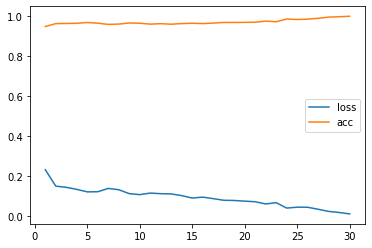

In [ ]:
import matplotlib.pyplot as plt
x = [i for i in range(1, 31)]
plt.plot(x, history.history['loss'], label='loss')
plt.plot(x, history.history['accuracy'], label='acc')
plt.legend()
plt.show()

In [ ]:
from sklearn.metrics import f1_score, precision_score, recall_score

In [ ]:
for i in range(64):
    test_place = np.expand_dims(place_sim_svd[i], 0)
    test_cast = np.expand_dims(cast_sim_svd[i], 0)
    test_action = np.expand_dims(action_sim_svd[i], 0)
    test_audio = np.expand_dims(audio_sim_svd[i], 0)
    test = {
        'place_input': test_place,
        'cast_input': test_cast,
        'action_input': test_action,
        'audio_input': test_audio
    }
    pred = model_sim_1.predict(test)
    _pred = pred[0, :, 0]
    _pred = list(map(lambda x:1 if x > 0.5 else 0, _pred))
    print('F1 score: ', f1_score(truth[i], _pred), 'Precision score: ', precision_score(truth[i], _pred), 'Recall score: ', recall_score(truth[i], _pred))

F1 score:  0.9248554913294798 Precision score:  1.0 Recall score:  0.8602150537634409
F1 score:  0.8470588235294119 Precision score:  1.0 Recall score:  0.7346938775510204
F1 score:  0.7741935483870968 Precision score:  1.0 Recall score:  0.631578947368421
F1 score:  0.819672131147541 Precision score:  1.0 Recall score:  0.6944444444444444
F1 score:  0.5211267605633803 Precision score:  1.0 Recall score:  0.3523809523809524
F1 score:  0.7051282051282052 Precision score:  0.9821428571428571 Recall score:  0.55
F1 score:  0.759493670886076 Precision score:  1.0 Recall score:  0.6122448979591837
F1 score:  0.7397260273972603 Precision score:  1.0 Recall score:  0.5869565217391305
F1 score:  0.684931506849315 Precision score:  1.0 Recall score:  0.5208333333333334
F1 score:  0.8294930875576036 Precision score:  1.0 Recall score:  0.7086614173228346
F1 score:  0.4940239043824701 Precision score:  1.0 Recall score:  0.328042328042328
F1 score:  0.8469387755102041 Precision score:  1.0 Recall

In [ ]:
model_sim_1.save_weights('/content/drive/MyDrive/Eluvio_movie_data/conv_bi_lstm_sim_model.h5')

In [ ]:
%%time
history2 = model_sim_1.fit_generator(gen_sim_1, steps_per_epoch=8, epochs=20, verbose=1)

/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/engine/training.py:1844: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  warnings.warn('`Model.fit_generator` is deprecated and '


Epoch 1/20
8/8 [==============================] - 10s 1s/step - loss: 0.0126 - accuracy: 0.9965
Epoch 2/20
8/8 [==============================] - 10s 1s/step - loss: 0.0085 - accuracy: 0.9982
Epoch 3/20
8/8 [==============================] - 10s 1s/step - loss: 0.0054 - accuracy: 0.9992
Epoch 4/20
8/8 [==============================] - 10s 1s/step - loss: 0.0072 - accuracy: 0.9986
Epoch 5/20
8/8 [==============================] - 10s 1s/step - loss: 0.0075 - accuracy: 0.9979
Epoch 6/20
8/8 [==============================] - 10s 1s/step - loss: 0.0028 - accuracy: 0.9998
Epoch 7/20
8/8 [==============================] - 10s 1s/step - loss: 0.0030 - accuracy: 0.9998
Epoch 8/20
8/8 [==============================] - 10s 1s/step - loss: 0.0015 - accuracy: 1.0000
Epoch 9/20
8/8 [==============================] - 10s 1s/step - loss: 0.0059 - accuracy: 0.9986
Epoch 10/20
8/8 [==============================] - 10s 1s/step - loss: 0.0028 - accuracy: 0.9997
Epoch 11/20
8/8 [======================

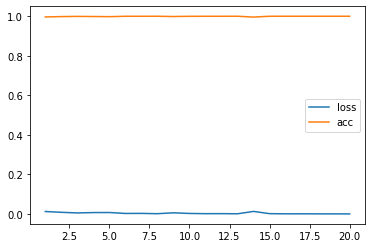

In [ ]:
x = [i for i in range(1, 21)]
plt.plot(x, history2.history['loss'], label='loss')
plt.plot(x, history2.history['accuracy'], label='acc')
plt.legend()
plt.show()

In [ ]:
avg_f1 = 0
avg_precision = 0
avg_recall = 0
for i in range(64):
    test_place = np.expand_dims(place_sim_svd[i], 0)
    test_cast = np.expand_dims(cast_sim_svd[i], 0)
    test_action = np.expand_dims(action_sim_svd[i], 0)
    test_audio = np.expand_dims(audio_sim_svd[i], 0)
    test = {
        'place_input': test_place,
        'cast_input': test_cast,
        'action_input': test_action,
        'audio_input': test_audio
    }
    pred = model_sim_1.predict(test)
    _pred = pred[0, :, 0]
    _pred = list(map(lambda x:1 if x > 0.5 else 0, _pred))
    f1 = f1_score(truth[i], _pred)
    precision = precision_score(truth[i], _pred)
    recall = recall_score(truth[i], _pred)
    avg_f1 += f1
    avg_precision += precision
    avg_recall += recall
    print('F1 score: ', format(f1, '.3f') , 'Precision score: ', format(precision, '.3f') , 'Recall score: ', format(recall, '.3f'))
print('avg F1 score: ', avg_f1 / 64, 'avg Precision score: ', avg_precision / 64 , 'avg Recall score: ', avg_recall / 64)

F1 score:  1.000 Precision score:  1.000 Recall score:  1.000
F1 score:  1.000 Precision score:  1.000 Recall score:  1.000
F1 score:  0.987 Precision score:  0.974 Recall score:  1.000
F1 score:  1.000 Precision score:  1.000 Recall score:  1.000
F1 score:  1.000 Precision score:  1.000 Recall score:  1.000
F1 score:  0.995 Precision score:  1.000 Recall score:  0.990
F1 score:  1.000 Precision score:  1.000 Recall score:  1.000
F1 score:  1.000 Precision score:  1.000 Recall score:  1.000
F1 score:  1.000 Precision score:  1.000 Recall score:  1.000
F1 score:  0.996 Precision score:  1.000 Recall score:  0.992
F1 score:  1.000 Precision score:  1.000 Recall score:  1.000
F1 score:  0.996 Precision score:  1.000 Recall score:  0.991
F1 score:  0.997 Precision score:  1.000 Recall score:  0.993
F1 score:  0.997 Precision score:  1.000 Recall score:  0.994
F1 score:  0.996 Precision score:  1.000 Recall score:  0.992
F1 score:  0.995 Precision score:  1.000 Recall score:  0.991
F1 score

In [ ]:
model_sim_1.save_weights('/content/drive/MyDrive/Eluvio_movie_data/conv_bi_lstm_sim_model_50epochs.h5')

## **load model using the pretrained weights**

In [32]:
model_sim_1.load_weights('/content/drive/MyDrive/Eluvio_movie_data/conv_bi_lstm_sim_model_50epochs.h5')

## **final evaluation: using the provided metrics**
in the previous section, I have evaluate the model using f1, precision and recall. and it performs very well. <br>

in this section, I will use the provided two metrics to evaluate the model. <br>

I need to modify the provided funcs a little bit to make it suitable for my predictions' shape

In [33]:
from sklearn.metrics import average_precision_score

In [36]:
preds = []
for i in tqdm(range(64)):
    test_place = np.expand_dims(place_sim_svd[i], 0)
    test_cast = np.expand_dims(cast_sim_svd[i], 0)
    test_action = np.expand_dims(action_sim_svd[i], 0)
    test_audio = np.expand_dims(audio_sim_svd[i], 0)
    test = {
        'place_input': test_place,
        'cast_input': test_cast,
        'action_input': test_action,
        'audio_input': test_audio
    }
    pred = model_sim_1.predict(test)
    preds.append(pred[0, :, 0])

100%|██████████| 64/64 [00:48<00:00,  1.32it/s]


In [38]:
imdb = []
filenames = []
for f in glob.glob(dir+'/*'):
    if f.endswith('pkl'):
        imdb.append(f[-13:-4])

**the reason I use t[1:] and p[1:] is when I trained the model, in order to make the seq_len of the training features the same as the gts', I add an 0 in front of each ground truth**

In [64]:
gt_dict = {}
for id, t in zip(imdb, truth):
    gt_dict[id]=t[1:]

In [65]:
pr_dict = {}
for id,  p in zip(imdb, preds):
    pr_dict[id]=p[1:]

### mAP

In [43]:
def calc_ap(gt_dict, pr_dict):
    """Average Precision (AP) for scene transitions.
    Args:
        gt_dict: Scene transition ground-truths.
        pr_dict: Scene transition predictions.
    Returns:
        AP, mean AP, and a dict of AP for each movie.
    """
    assert gt_dict.keys() == pr_dict.keys()

    AP_dict = dict()
    gt = list()
    pr = list()
    for imdb_id in gt_dict.keys():
        AP_dict[imdb_id] = average_precision_score(gt_dict[imdb_id], pr_dict[imdb_id])
        gt.append(gt_dict[imdb_id])
        pr.append(pr_dict[imdb_id])

    mAP = sum(AP_dict.values()) / len(AP_dict)

    gt = np.concatenate(gt)
    pr = np.concatenate(pr)
    AP = average_precision_score(gt, pr)

    return AP, mAP, AP_dict

In [66]:
scores = {}
scores["AP"], scores["mAP"], _ = calc_ap(gt_dict, pr_dict)

### mean MIoU


In [68]:
def calc_miou(gt_dict, pr_dict, shot_to_end_frame_dict, threshold=0.5):
    """Maximum IoU (Miou) for scene segmentation.
    Miou measures how well the predicted scenes and ground-truth scenes overlap. The descriptions can be found in
    https://arxiv.org/pdf/1510.08893.pdf. Note the length of intersection or union is measured by the number of frames.
    Args:
        gt_dict: Scene transition ground-truths.
        pr_dict: Scene transition predictions.
        shot_to_end_frame_dict: End frame index for each shot.
        threshold: A threshold to filter the predictions.
    Returns:
        Mean MIoU, and a dict of MIoU for each movie.
    """
    def iou(x, y):
        s0, e0 = x
        s1, e1 = y
        smin, smax = (s0, s1) if s1 > s0 else (s1, s0)
        emin, emax = (e0, e1) if e1 > e0 else (e1, e0)
        return (emin - smax + 1) / (emax - smin + 1)

    def scene_frame_ranges(scene_transitions, shot_to_end_frame):
        end_shots = np.where(scene_transitions)[0]
        scenes = np.zeros((len(end_shots) + 1, 2), dtype=end_shots.dtype)
        scenes[:-1, 1] = shot_to_end_frame[end_shots]
        scenes[-1, 1] = shot_to_end_frame[len(scene_transitions)]
        scenes[1:, 0] = scenes[:-1, 1] + 1
        return scenes

    def miou(gt_array, pr_array, shot_to_end_frame):
        gt_scenes = scene_frame_ranges(gt_array, shot_to_end_frame)
        pr_scenes = scene_frame_ranges(pr_array >= threshold, shot_to_end_frame)
        assert gt_scenes[-1, -1] == pr_scenes[-1, -1]

        m = gt_scenes.shape[0]
        n = pr_scenes.shape[0]

        # IoU for (gt_scene, pr_scene) pairs
        iou_table = np.zeros((m, n))

        j = 0
        for i in range(m):
            # j start prior to i end
            while pr_scenes[j, 0] <= gt_scenes[i, 1]:
                iou_table[i, j] = iou(gt_scenes[i], pr_scenes[j])
                if j < n - 1:
                    j += 1
                else:
                    break
            # j end prior to (i + 1) start
            if pr_scenes[j, 1] < gt_scenes[i, 1] + 1:
                break
            # j start later than (i + 1) start
            if pr_scenes[j, 0] > gt_scenes[i, 1] + 1:
                j -= 1
        assert np.isnan(iou_table).sum() == 0
        assert iou_table.min() >= 0

        # Miou
        return (iou_table.max(axis=0).mean() + iou_table.max(axis=1).mean()) / 2

    assert gt_dict.keys() == pr_dict.keys()

    miou_dict = dict()

    for imdb_id in gt_dict.keys():
        miou_dict[imdb_id] = miou(gt_dict[imdb_id], pr_dict[imdb_id], shot_to_end_frame_dict[imdb_id])
    mean_miou = sum(miou_dict.values()) / len(miou_dict)

    return mean_miou, miou_dict

In [57]:
shot_to_end_frames = []
for f in glob.glob(dir+'/*'):
    if f.endswith('pkl'):
        dic = pd.read_pickle(f)
        shot_to_end_frames.append(np.array(dic['shot_end_frame']))

In [63]:
shot_to_end_frame_dict = {}
for id, stef in zip(imdb, shot_to_end_frames):
    shot_to_end_frame_dict[id] = stef

In [69]:
scores["Miou"], _ = calc_miou(gt_dict, pr_dict, shot_to_end_frame_dict)

## **finally**

In [70]:
 print("Scores:", json.dumps(scores, indent=4))

Scores: {
    "AP": 0.9999021271237725,
    "mAP": 0.999924259895848,
    "Miou": 0.9956055967853431
}
